In [1]:
#!pip install cloudant

In [2]:
#!pip install h2o

In [3]:
#!pip install scikit-learn --upgrade

In [4]:
#!pip install lightgbm --upgrade

In [5]:
#!pip install xgboost --upgrade

In [6]:
#!pip install imblearn --upgrade

In [7]:
#!pip install holidays

In [12]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import Series
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from datetime import date
from datetime import timedelta
import holidays


from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [20]:
# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    print("Linhas do dataset até o momento:")
    print(data.shape)

    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("\nLinhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('\nÓtimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df, treino=True):
    
    if treino:
        df.dropna(axis='index', how='any', subset=['Tempo', 'Estacao',
                                                   'Movimentacao', 'Original_473', 
                                                   'Original_269', 'Zero', 'Maca_Verde', 
                                                   'Tangerina', 'Citrus', 'Acai_Guarana', 
                                                   'Pessego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def feature_engineering(df, treino=True):

    if treino:
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')

        # Removendo colunas unicas
        df = df.drop(['LAT','LONG','row'], axis = 1)

        # Verificar os registros duplicados
        verify_dup_rows(df)

        # Removendo registros duplicados
        df = df.drop_duplicates().reset_index(drop=True)
    
    else:
        # Corrige dados incorretos
        teste.loc[teste.index == 89, 'Tempo'] = "2019-02-28 01:00:00"
        teste.loc[teste.index == 90, 'Tempo'] = "2019-02-28 02:00:00"

        teste.loc[teste.index == 449, 'Tempo'] = "2018-02-28 01:00:00"
        teste.loc[teste.index == 450, 'Tempo'] = "2018-02-28 02:00:00"

        teste.loc[teste.index == 809, 'Tempo'] = "2019-02-28 01:00:00"
        teste.loc[teste.index == 810, 'Tempo'] = "2019-02-28 02:00:00"
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')
        
        # Removendo colunas unicas
        df = df.drop(['LAT','LONG'], axis = 1)

    return df

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['Estacao'])

    return df    

In [24]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
train = pd.read_csv(r'train_17015.csv')

# Feature Engineering
treino = preenche_missing(train, True)    
treino = feature_engineering(treino, True) 

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print('\nLinhas unicas até o momento:')
print(treino.shape)

Linhas do dataset até o momento:
(17015, 12)

Linhas duplicadas até o momento:
(0, 12)

Ótimo! Não há mais valores faltantes neste dataset.

Linhas unicas até o momento:
(17015, 12)


In [25]:
treino.head()

,Tempo,Estacao,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,2019-12-30,Fradique Coutinho,35386,24,45,61,42,19,22,15,9,NORMAL
1,2018-01-08,Luz,124806,15,10,10,29,10,25,14,13,NORMAL
2,2018-04-17,Luz,125215,53,1,55,18,18,6,37,8,REABASTECER
3,2018-07-18,Luz,126476,36,5,57,38,15,43,43,18,REABASTECER
4,2018-08-28,Luz,125917,79,10,8,37,32,30,18,15,NORMAL


In [26]:
# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')

# Feature Engineering
teste = preenche_missing(test, False)    
teste = feature_engineering(teste, False) 

# Verificando as colunas com dados missing do dataset
check_missing(teste, display = 15)

print('\nLinhas unicas no dataset de teste:')
print(teste.shape)


Ótimo! Não há mais valores faltantes neste dataset.

Linhas unicas no dataset de teste:
(984, 11)


In [27]:
treino['Estacao'].value_counts()

Barra Funda               720
República                 720
Sé                        720
Paraíso                   720
Ana Rosa                  720
Brigadeiro                720
São Joaquim               720
Brás                      720
Brooklin                  720
Eucaliptos                720
Butantã                   720
Trianon-Masp              720
Fradique Coutinho         720
Faria Lima                720
Higienópolis-Mackenzie    720
Pinheiros                 720
Campo Belo                720
São Judas                 720
Consolação                720
Tatuapé                   720
Tamanduateí               720
Vila Mariana              720
Luz                       719
Moema                     329
Hospital São Paulo        127
Name: Estacao, dtype: int64

In [29]:
teste['Estação'].value_counts()

Hospital São Paulo    593
Moema                 391
Name: Estação, dtype: int64

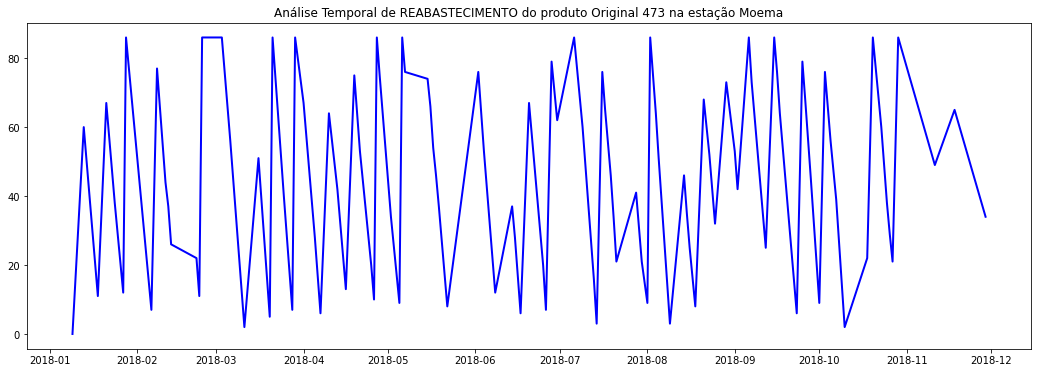

In [30]:
ts_moema = treino[treino['Estacao'] == 'Moema'][['Tempo','Original_473','TARGET']].sort_values(by=['Tempo'])
ts_moema.dropna(inplace=True)
ts_moema = ts_moema.set_index('Tempo')
ts_moema = ts_moema[ts_moema['TARGET'] == 'REABASTECER']

# Plot da Série Temporal
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
ax.plot(ts_moema.index, (ts_moema['Original_473']), alpha = 1, color ='b', ls = 'solid', linewidth=2)

# Evento: REABASTECIMENTO
#for i in range(0,ts_moema[ts_moema['TARGET'] == 'REABASTECER'].shape[0]):
#    ax.axvspan(*mdates.datestr2num([str(ts_moema.index[i]), str(ts_moema.index[i]+timedelta(days=1))]), color='gray', alpha=0.5)

ax.set_title('Análise Temporal de REABASTECIMENTO do produto Original 473 na estação Moema');

In [31]:
# Verificando a quantidade minima entre as latinhas por dia, que tinha na estacao Moema
tmp = treino[treino['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp.dropna(inplace=True)
tmp = tmp.set_index('Tempo')
tmp.style.highlight_min(color = 'red', axis = 1) 

ValueError: style is not supported for non-unique indices.

In [ ]:
tmp = treino[['Tempo','Estacao','TARGET']].sort_values(by=['Estacao','Tempo'])
tmp['TARGET'] = tmp['TARGET'].astype('category')
tmp['TARGET'] = tmp["TARGET"].cat.codes
tmp = pd.pivot_table(tmp,index=['Tempo'],values=['TARGET'],columns=["Estacao"],fill_value=0)
tmp.columns = tmp.columns.droplevel(0)
tmp.columns.name = None
tmp = tmp.reset_index() 
tmp.style.highlight_max(color = 'lightgreen', axis = 0) 

In [ ]:
treino['Estação'].value_counts()

In [ ]:
plt.figure(figsize=(20, 12))

# Selecionando apenas algumas colunas para verificar a correlação
corr = tmp.corr(method = 'pearson')

# Configurar o heatmap
sns.heatmap(corr, linewidths=.5, vmin=-1, vmax=1, annot=True, cmap="YlGnBu", fmt='.1g')

# Imprimir o grafico
plt.show();

In [ ]:
# Verificando a quantidade maxima entre as latinhas por dia, que tinha na estacao Moema
tmp = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai-Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp.dropna(inplace=True)
tmp = tmp.set_index('Tempo')
tmp.style.highlight_min(color = 'lightgreen', axis = 1) 

# VERIFICANDO CORRELACAO DE REABASTECIMENTO COM OUTRAS ESTACOES

# FAZENDO PREVISAO MANUALMENTE

In [ ]:
# Aplicando formula manualmente considerando o volume maximo de cada latinha na estacao
def conditions2(data):
    if ((data['Original_473_diff'] < 0) or \
        (data['Original_269_diff'] < 0) or \
        (data['Zero_diff'] < 0) or \
        (data['Maca_Verde_diff'] < 0) or \
        (data['Tangerina_diff'] < 0) or \
        (data['Citrus_diff'] < 0) or \
        (data['Acai_Guarana_diff'] < 0) or \
        (data['Pessego_diff'] < 0)):

        return 'REABASTECER'
    
    else:
        return 'NORMAL'

In [ ]:
# Percorrendo o dataset de treino e fazendo previsoes manualmente
# Verificando o % de acerto
for i in treino['Estacao'].unique():

    tmp = treino[treino['Estacao'] == i][['Tempo','Estacao','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
    tmp.dropna(inplace=True)
    print('Estacao: '+ i)
    print(tmp['Tempo'].min())
    print(tmp['Tempo'].max())
    tmp = tmp.set_index('Tempo')

    tmp['Original_473_lag_1'] = tmp['Original_473'].shift(-1)
    tmp['Original_269_lag_1'] = tmp['Original_269'].shift(-1)
    tmp['Zero_lag_1']         = tmp['Zero'].shift(-1)
    tmp['Maca_Verde_lag_1']   = tmp['Maca_Verde'].shift(-1)
    tmp['Tangerina_lag_1']    = tmp['Tangerina'].shift(-1)
    tmp['Citrus_lag_1']       = tmp['Citrus'].shift(-1)
    tmp['Acai_Guarana_lag_1'] = tmp['Acai_Guarana'].shift(-1)
    tmp['Pessego_lag_1']      = tmp['Pessego'].shift(-1)

    tmp['Original_473_diff'] = tmp['Original_473'] - tmp['Original_473_lag_1']
    tmp['Original_269_diff'] = tmp['Original_269'] - tmp['Original_269_lag_1']
    tmp['Zero_diff']         = tmp['Zero'] - tmp['Zero_lag_1']
    tmp['Maca_Verde_diff']   = tmp['Maca_Verde'] - tmp['Maca_Verde_lag_1']
    tmp['Tangerina_diff']    = tmp['Tangerina'] - tmp['Tangerina_lag_1']
    tmp['Citrus_diff']       = tmp['Citrus']- tmp['Citrus_lag_1']
    tmp['Acai_Guarana_diff'] = tmp['Acai_Guarana'] - tmp['Acai_Guarana_lag_1']
    tmp['Pessego_diff']      = tmp['Pessego'] - tmp['Pêssego_lag_1']

    tmp['TARGET_PRED'] = tmp.apply(conditions2, axis=1)

    tmp = tmp[['Estacao','TARGET','TARGET_PRED']]

    tmp['ERROS'] = np.where(tmp['TARGET']==tmp['TARGET_PRED'], 0, 1)

    print('Acuracia: ' + str(round((1-(tmp['ERROS'].sum(axis=0)/tmp.shape[0]))*100,2)))
    print('\n')

In [ ]:
tmp = treino[treino['Estacao'] == 'Moema'][['Tempo','Estacao','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp.dropna(inplace=True)
print('Estacao: '+ i)
print(tmp['Tempo'].min())
print(tmp['Tempo'].max())
tmp = tmp.set_index('Tempo')

tmp['Original_473_lag_1'] = tmp['Original_473'].shift(-1)
tmp['Original_269_lag_1'] = tmp['Original_269'].shift(-1)
tmp['Zero_lag_1']         = tmp['Zero'].shift(-1)
tmp['Maca_Verde_lag_1']   = tmp['Maca_Verde'].shift(-1)
tmp['Tangerina_lag_1']    = tmp['Tangerina'].shift(-1)
tmp['Citrus_lag_1']       = tmp['Citrus'].shift(-1)
tmp['Acai_Guarana_lag_1'] = tmp['Acai_Guarana'].shift(-1)
tmp['Pessego_lag_1']      = tmp['Pessego'].shift(-1)

tmp['Original_473_diff'] = tmp['Original_473'] - tmp['Original_473_lag_1']
tmp['Original_269_diff'] = tmp['Original_269'] - tmp['Original_269_lag_1']
tmp['Zero_diff']         = tmp['Zero'] - tmp['Zero_lag_1']
tmp['Maca_Verde_diff']   = tmp['Maca_Verde'] - tmp['Maca_Verde_lag_1']
tmp['Tangerina_diff']    = tmp['Tangerina'] - tmp['Tangerina_lag_1']
tmp['Citrus_diff']       = tmp['Citrus']- tmp['Citrus_lag_1']
tmp['Acai_Guarana_diff'] = tmp['Acai_Guarana'] - tmp['Acai_Guarana_lag_1']
tmp['Pessego_diff']      = tmp['Pessego'] - tmp['Pêssego_lag_1']

tmp['TARGET_PRED'] = tmp.apply(conditions2, axis=1)

tmp = tmp[['Estacao','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET','TARGET_PRED']]

tmp['ERROS'] = np.where(tmp['TARGET']==tmp['TARGET_PRED'], 0, 1)

#tmp = tmp[tmp['ERROS'] == 1]
#tmp = tmp[['Estação','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET','TARGET_PRED']]
tmp = tmp[['Estacao','Original_473','TARGET','TARGET_PRED']]

tmp.style.highlight_min(color = 'lightgreen', axis = 1) 

In [ ]:
# Verificando a data inicial e final das estacoes
# Hospital São Paulo
tmp = treino[treino['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp = tmp[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pêssego']]

print('TREINO: Estacao: Moema')
print(tmp['Tempo'].min())
print(tmp['Tempo'].max())

print('\n')

tmp2 = teste[teste['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp2 = tmp2[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pêssego']]

print('TESTE: Estacao: Moema')
print(tmp2['Tempo'].min())
print(tmp2['Tempo'].max())

In [ ]:
# Verificando a data inicial e final das estacoes
# Hospital São Paulo
tmp = treino[treino['Estacao'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp = tmp[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']]

print('TREINO: Estacao: Hospital São Paulo')
print(tmp['Tempo'].min())
print(tmp['Tempo'].max())

print('\n')

tmp2 = teste[teste['Estacao'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp2 = tmp2[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pessego']]

print('TESTE: Estacao: Hospital São Paulo')
print(tmp2['Tempo'].min())
print(tmp2['Tempo'].max())

# TREINANDO O MODELO PARA CADA ESTACAO

In [ ]:
print('PREVISAO DA ESTACAO: Moema')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pessego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pessego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_moema = pd.concat([tmp_treino, tmp_teste])
df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']]
df_moema = df_moema.set_index('Tempo')

df_moema['Original_473_lag_1'] = df_moema['Original_473'].shift(-1)
df_moema['Original_269_lag_1'] = df_moema['Original_269'].shift(-1)
df_moema['Zero_lag_1']         = df_moema['Zero'].shift(-1)
df_moema['Maca_Verde_lag_1']   = df_moema['Maca_Verde'].shift(-1)
df_moema['Tangerina_lag_1']    = df_moema['Tangerina'].shift(-1)
df_moema['Citrus_lag_1']       = df_moema['Citrus'].shift(-1)
df_moema['Acai_Guarana_lag_1'] = df_moema['Acai_Guarana'].shift(-1)
df_moema['Pessego_lag_1']      = df_moema['Pessego'].shift(-1)

df_moema['Original_473_diff'] = df_moema['Original_473'] - df_moema['Original_473_lag_1']
df_moema['Original_269_diff'] = df_moema['Original_269'] - df_moema['Original_269_lag_1']
df_moema['Zero_diff']         = df_moema['Zero'] - df_moema['Zero_lag_1']
df_moema['Maca_Verde_diff']   = df_moema['Maca_Verde'] - df_moema['Maca_Verde_lag_1']
df_moema['Tangerina_diff']    = df_moema['Tangerina'] - df_moema['Tangerina_lag_1']
df_moema['Citrus_diff']       = df_moema['Citrus']- df_moema['Citrus_lag_1']
df_moema['Acai_Guarana_diff'] = df_moema['Acai_Guarana'] - df_moema['Acai_Guarana_lag_1']
df_moema['Pessego_diff']      = df_moema['Pessego'] - df_moema['Pessego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_moema = df_moema.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maca_Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Acai_Guarana_lag_1','Pessego_lag_1'], axis = 1)
    
# Removendo todos os registros de teste    
df_moema.dropna(inplace=True)
df_moema = df_moema.reset_index()
print(df_moema.columns)

data_split = '2018-06-30'

X_train = df_moema[(df_moema['Tempo'] <= data_split)]
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','Tempo'], axis = 1)

X_valid = df_moema[(df_moema['Tempo'] > data_split)]
y_valid = X_valid['TARGET']
X_valid = X_valid.drop(['TARGET','Tempo'], axis = 1)

print('Dados Treino: ', X_train.shape)
print('Dados Validacao: ',X_valid.shape)

# Treinamento com XGB
model_xgb_moema = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb_moema.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))


In [ ]:
xgb.plot_importance(model_xgb_moema)
plt.figure(figsize = (18, 28))
plt.show()

In [ ]:
print('PREVISAO DA ESTACAO: Hospital São Paulo')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estacao'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estacao'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_hsp = pd.concat([tmp_teste, tmp_treino])
df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']]
df_hsp = df_hsp.set_index('Tempo')

df_hsp['Original_473_lag_1'] = df_hsp['Original_473'].shift(-1)
df_hsp['Original_269_lag_1'] = df_hsp['Original_269'].shift(-1)
df_hsp['Zero_lag_1']         = df_hsp['Zero'].shift(-1)
df_hsp['Maca_Verde_lag_1']   = df_hsp['Maca_Verde'].shift(-1)
df_hsp['Tangerina_lag_1']    = df_hsp['Tangerina'].shift(-1)
df_hsp['Citrus_lag_1']       = df_hsp['Citrus'].shift(-1)
df_hsp['Acai_Guarana_lag_1'] = df_hsp['Acai_Guarana'].shift(-1)
df_hsp['Pessego_lag_1']      = df_hsp['Pessego'].shift(-1)

df_hsp['Original_473_diff'] = df_hsp['Original_473'] - df_hsp['Original_473_lag_1']
df_hsp['Original_269_diff'] = df_hsp['Original_269'] - df_hsp['Original_269_lag_1']
df_hsp['Zero_diff']         = df_hsp['Zero'] - df_hsp['Zero_lag_1']
df_hsp['Maca_Verde_diff']   = df_hsp['Maca_Verde'] - df_hsp['Maca_Verde_lag_1']
df_hsp['Tangerina_diff']    = df_hsp['Tangerina'] - df_hsp['Tangerina_lag_1']
df_hsp['Citrus_diff']       = df_hsp['Citrus']- df_hsp['Citrus_lag_1']
df_hsp['Acai_Guarana_diff'] = df_hsp['Acai_Guarana'] - df_hsp['Acai_Guarana_lag_1']
df_hsp['Pessego_diff']      = df_hsp['Pessego'] - df_hsp['Pessego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_hsp = df_hsp.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maca_Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Acai_Guarana_lag_1','Pessego_lag_1'], axis = 1)
    
# Removendo todos os registros de teste    
df_hsp.dropna(inplace=True)
df_hsp = df_hsp.reset_index()

data_split = '2019-10-30'

X_train = df_hsp[(df_hsp['Tempo'] <= data_split)]
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','Tempo'], axis = 1)

X_valid = df_hsp[(df_hsp['Tempo'] > data_split)]
y_valid = X_valid['TARGET']
X_valid = X_valid.drop(['TARGET','Tempo'], axis = 1)

print('Dados Treino: ', X_train.shape)
print('Dados Validacao: ',X_valid.shape)

# Treinamento com XGB
model_xgb_hsp = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb_hsp.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))


In [ ]:
xgb.plot_importance(model_xgb_hsp)
plt.figure(figsize = (18, 28))
plt.show()

# FAZENDO PREVISOES

In [ ]:
print('PREVISAO DA ESTACAO: Moema')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estacao'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guaraná','Pessego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_moema = pd.concat([tmp_treino, tmp_teste])

# Apenas dados de teste 
df_moema = df_moema[df_moema['dataset'] == 'TESTE']
df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']]
df_moema = df_moema.set_index('Tempo')

df_moema['Original_473_lag_1'] = df_moema['Original_473'].shift(-1)
df_moema['Original_269_lag_1'] = df_moema['Original_269'].shift(-1)
df_moema['Zero_lag_1']         = df_moema['Zero'].shift(-1)
df_moema['Maca_Verde_lag_1']   = df_moema['Maca_Verde'].shift(-1)
df_moema['Tangerina_lag_1']    = df_moema['Tangerina'].shift(-1)
df_moema['Citrus_lag_1']       = df_moema['Citrus'].shift(-1)
df_moema['Acai_Guarana_lag_1'] = df_moema['Acai_Guarana'].shift(-1)
df_moema['Pessego_lag_1']      = df_moema['Pessego'].shift(-1)

df_moema['Original_473_diff'] = df_moema['Original_473'] - df_moema['Original_473_lag_1']
df_moema['Original_269_diff'] = df_moema['Original_269'] - df_moema['Original_269_lag_1']
df_moema['Zero_diff']         = df_moema['Zero'] - df_moema['Zero_lag_1']
df_moema['Maca_Verde_diff']   = df_moema['Maca_Verde'] - df_moema['Maca_Verde_lag_1']
df_moema['Tangerina_diff']    = df_moema['Tangerina'] - df_moema['Tangerina_lag_1']
df_moema['Citrus_diff']       = df_moema['Citrus']- df_moema['Citrus_lag_1']
df_moema['Acai_Guaraná_diff'] = df_moema['Acai_Guarana'] - df_moema['Acai_Guarana_lag_1']
df_moema['Pessego_diff']      = df_moema['Pessego'] - df_moema['Pessego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_moema = df_moema.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maca_Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Acai_Guarana_lag_1','Pessego_lag_1'], axis = 1)
df_moema = df_moema.reset_index()

X_teste = df_moema.drop(['Tempo'], axis = 1)

# Validacao do modelo
y_pred_teste = model_xgb_moema.predict(X_teste)


df_moema['TARGET_MODELO'] = y_pred_teste
df_moema['TARGET_RODRIGO'] = df_moema.apply(conditions2, axis=1)


df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET_MODELO','TARGET_RODRIGO']]
df_moema.style.highlight_min(color = 'lightgreen', axis = 1) 
#df_moema

In [ ]:
print('PREVISAO DA ESTACAO: Hospital São Paulo')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estacao'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_hsp = pd.concat([tmp_teste, tmp_treino])

# Apenas dados de teste 
df_hsp = df_hsp[df_hsp['dataset'] == 'TESTE']
df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego']]
df_hsp = df_hsp.set_index('Tempo')

df_hsp['Original_473_lag_1'] = df_hsp['Original_473'].shift(-1)
df_hsp['Original_269_lag_1'] = df_hsp['Original_269'].shift(-1)
df_hsp['Zero_lag_1']         = df_hsp['Zero'].shift(-1)
df_hsp['Maca_Verde_lag_1']   = df_hsp['Maca_Verde'].shift(-1)
df_hsp['Tangerina_lag_1']    = df_hsp['Tangerina'].shift(-1)
df_hsp['Citrus_lag_1']       = df_hsp['Citrus'].shift(-1)
df_hsp['Acai_Guaraná_lag_1'] = df_hsp['Acai_Guarana'].shift(-1)
df_hsp['Pessego_lag_1']      = df_hsp['Pessego'].shift(-1)

df_hsp['Original_473_diff'] = df_hsp['Original_473'] - df_hsp['Original_473_lag_1']
df_hsp['Original_269_diff'] = df_hsp['Original_269'] - df_hsp['Original_269_lag_1']
df_hsp['Zero_diff']         = df_hsp['Zero'] - df_hsp['Zero_lag_1']
df_hsp['Maca_Verde_diff']   = df_hsp['Maca_Verde'] - df_hsp['Maca_Verde_lag_1']
df_hsp['Tangerina_diff']    = df_hsp['Tangerina'] - df_hsp['Tangerina_lag_1']
df_hsp['Citrus_diff']       = df_hsp['Citrus']- df_hsp['Citrus_lag_1']
df_hsp['Acai_Guarana_diff'] = df_hsp['Acai_Guarana'] - df_hsp['Acai_Guarana_lag_1']
df_hsp['Pessego_diff']      = df_hsp['Pessego'] - df_hsp['Pessego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_hsp = df_hsp.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maca_Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Acai_Guarana_lag_1','Pessego_lag_1'], axis = 1)
df_hsp = df_hsp.reset_index()

X_teste = df_hsp.drop(['Tempo'], axis = 1)

# Validacao do modelo
y_pred_teste = model_xgb_hsp.predict(X_teste)


df_hsp['TARGET_MODELO'] = y_pred_teste
df_hsp['TARGET_RODRIGO'] = df_hsp.apply(conditions2, axis=1)


df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET_MODELO','TARGET_RODRIGO']]
df_hsp

# RESULTADO FINAL COM A PREVISAO DO MODELO

In [ ]:
df_final = pd.concat([df_moema, df_hsp])
df_final = df_final[['Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET_MODELO']]
df_final = df_final.rename(columns={"TARGET_MODELO": "TARGET"})

# Gravando resultado em csv
df_final.to_csv('Desafio-7-results/results_modelo.csv',index=False)
print(df_final.shape)

# RESULTADO FINAL COM A PREVISAO DO RODRIGO (NA MAO)

In [ ]:
df_final = pd.concat([df_moema, df_hsp])
df_final = df_final[['Original_473','Original_269','Zero','Maca_Verde','Tangerina','Citrus','Acai_Guarana','Pessego','TARGET_RODRIGO']]
df_final = df_final.rename(columns={"TARGET_RODRIGO": "TARGET"})

# Gravando resultado em csv
df_final.to_csv('Desafio-7-results/results_rodrigo.csv',index=False)
print(df_final.shape)

# BACKUP DE CODIGO

In [ ]:
#tmp = tmp.reset_index(drop=True)
#tmp['qtde_total_dia'] = tmp.sum(axis=1)
#tmp['qtde_min_dia'] = tmp.min(axis=1)
#tmp['qtde_max_dia'] = tmp.max(axis=1)
#tmp['qtde_mean_dia'] = tmp.mean(axis=1)
#tmp['capacidade_total_estacao'] = tmp['qtde_max_dia'].max(axis=0)
#tmp['perc_abaixo_capacidade_total'] = tmp['qtde_min_dia'] / tmp['capacidade_total_estacao'] * 100
#tmp['perc_abaixo_qtde_dia'] = tmp['qtde_max_dia'] / tmp['capacidade_total_estacao'] * 100
#tmp = tmp[['Tempo','TARGET','qtde_min_dia','qtde_max_dia','qtde_mean_dia','capacidade_total_estacao','perc_abaixo_capacidade_total','perc_abaixo_qtde_dia']]